# Experimenting with Portfolio Optimization: Classical vs. Quantum Computing Approaches


### Importing nesssary libraries 

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
from qiskit_ibm_provider import IBMProvider
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import DiscreteAllocation
from qiskit_aer import AerSimulator
from qiskit_finance.applications.optimization import PortfolioOptimization
from collections import Counter
from qiskit_algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution

C:\Users\vansh\AppData\Local\Temp\ipykernel_9528\2934801846.py:9: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [7]:
plt.style.context('seaborn-v0_8-colorblind')

### Retrieving Market Data for Top and Bottom S&P 500 Stocks via YFinancee

In [8]:
tickers_to_get = ["MSFT","AAPL","NVDA","AMZN","META","MHK", 
           "NWS","FOX","GL","PARA"] 

In [19]:
ohlc = yf.download(tickers_to_get, period="5y")

[*********************100%%**********************]  10 of 10 completed


In [20]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

Ticker,AAPL,AMZN,FOX,GL,META,MHK,MSFT,NVDA,NWS,PARA
Date,,,,,,,,,,
2024-04-23,166.899994,179.539993,29.180000,75.760002,496.100006,113.440002,407.570007,824.229980,25.430000,12.740
2024-04-24,169.020004,176.589996,29.309999,78.599998,493.500000,111.400002,409.059998,796.770020,25.330000,12.680
2024-04-25,169.889999,173.669998,29.250000,75.540001,441.380005,110.269997,399.040009,826.320007,24.940001,12.180
2024-04-26,169.300003,179.619995,28.809999,75.750000,443.290009,115.449997,406.320007,877.349976,24.959999,11.910
2024-04-29,174.585007,180.552399,29.139999,78.719902,432.309998,118.455002,400.790009,871.722290,25.180000,12.315


#### Visualizing Adjusted Close Prices for Selected Stocks Since 2010


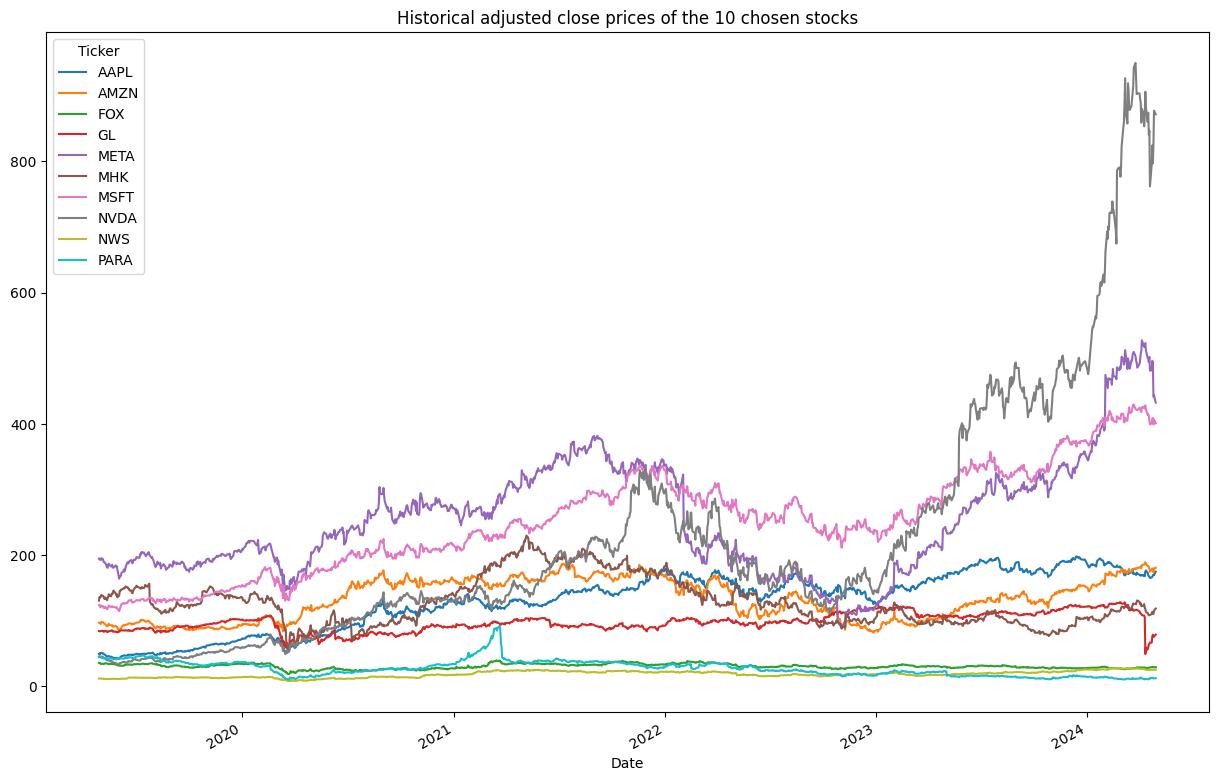

In [55]:
prices[prices.index >= "2010-01-01"].plot(figsize=(15,10));
plt.title('Historical adjusted close prices of the 10 chosen stocks')
plt.savefig("stock_prices.png")

## Implementing Classical Mean-Variance Optimization


In [22]:
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

Ticker,AAPL,AMZN,FOX,GL,META,MHK,MSFT,NVDA,NWS,PARA
Ticker,,,,,,,,,,
AAPL,0.101471,0.068268,0.038294,0.039260,0.081148,0.052152,0.072623,0.106140,0.047808,0.059000
AMZN,0.068268,0.123509,0.025481,0.023856,0.097375,0.039356,0.073223,0.110786,0.042660,0.044263
FOX,0.038294,0.025481,0.108072,0.052252,0.040610,0.079713,0.033083,0.047242,0.061685,0.116234
GL,0.039260,0.023856,0.052252,0.164352,0.041009,0.076646,0.038829,0.044713,0.055295,0.063261
META,0.081148,0.097375,0.040610,0.041009,0.198846,0.063303,0.084369,0.127414,0.058688,0.074892
MHK,0.052152,0.039356,0.079713,0.076646,0.063303,0.227607,0.048697,0.083474,0.083421,0.121487
MSFT,0.072623,0.073223,0.033083,0.038829,0.084369,0.048697,0.092404,0.111685,0.045274,0.045006
NVDA,0.106140,0.110786,0.047242,0.044713,0.127414,0.083474,0.111685,0.271762,0.071011,0.073314
NWS,0.047808,0.042660,0.061685,0.055295,0.058688,0.083421,0.045274,0.071011,0.118462,0.093122


In [23]:
mu = expected_returns.capm_return(prices)
mu

Ticker
AAPL    0.163473
AMZN    0.159729
FOX     0.149797
GL      0.149110
META    0.206868
MHK     0.208635
MSFT    0.158956
NVDA    0.245611
NWS     0.165899
PARA    0.242439
Name: mkt, dtype: float64

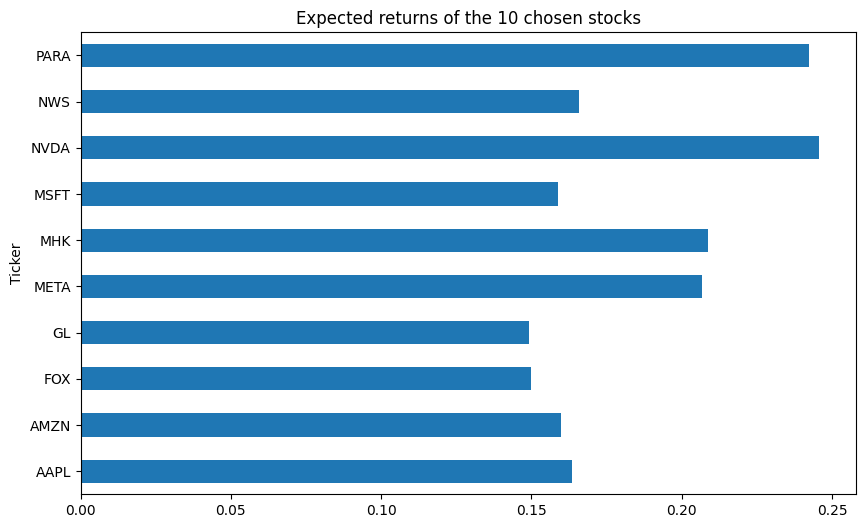

In [56]:
mu.plot.barh(figsize=(10,6));
plt.title('Expected returns of the 10 chosen stocks')
plt.savefig("expected_returns.png")

### Quadratic Utility Function

This function is used to maximize the quadratic utility, represented as:

![Quadratic Utility Function](max_func_classical.png)

The equation represents an optimization problem in portfolio theory, where:

- `\( \max_w \)` denotes the operation of maximizing over the choices of the vector `\( w \)`.
- `\( w \)` is a vector where each element represents the proportion of the total portfolio value invested in a different asset.
- `\( \mu \)` is a vector where each element represents the expected return of the corresponding asset in the portfolio.
- `\( w^T \)` denotes the transpose of vector `\( w \)`, which is used to convert row vectors to column vectors or vice versa.
- `\( \delta \)` is a scalar that represents the risk aversion coefficient, reflecting the investor's tolerance for risk.
- `\( \Sigma \)` is the covariance matrix of the asset returns, representing the interdependencies of the asset returns.
- `\( w^T\Sigma w \)` is a quadratic form representing the variance of the portfolio's returns, which is a measure of risk. of risk.

In [25]:
# Define the Efficient Frontier object
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

# Alternatively, define a custom objective
# risk_aversion_factor should be a positive number, where a higher value indicates more aversion to risk.
risk_aversion_factor = 1  # Example value, adjust based on your risk tolerance
ef.max_quadratic_utility(risk_aversion=risk_aversion_factor)

# Get the cleaned weights
weights = ef.clean_weights()

# Print the weights
weights

OrderedDict([('AAPL', 0.01032),
             ('AMZN', -0.04531),
             ('FOX', -0.13893),
             ('GL', 0.07461),
             ('META', 0.25888),
             ('MHK', 0.21946),
             ('MSFT', -0.11608),
             ('NVDA', 0.39657),
             ('NWS', 0.05036),
             ('PARA', 0.29012)])

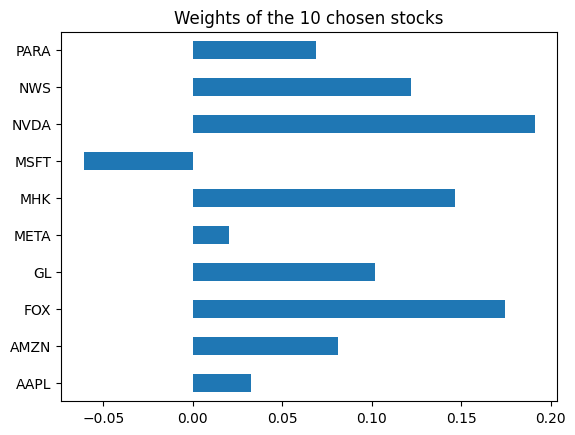

In [57]:
pd.Series(weights).plot.barh();
plt.title('Weights of the 10 chosen stocks')
plt.savefig("stock_weights.png")

In [27]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.2%
Annual volatility: 39.7%
Sharpe Ratio: 0.56


#### Discrete Portfolio Allocation

Using the optimized weights from mean-variance analysis, we can determine the discrete allocation of our portfolio. This is achieved by rounding the continuous weights to the nearest integer number of shares we can purchase within our budget constraints. The code below executes this step, providing us with the allocation and the amount of funds remaining.


In [28]:
latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc_class, leftover_class = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover_class:.2f} leftover")
alloc_class

Discrete allocation performed with $14.76 leftover


{'AAPL': 1,
 'GL': 15,
 'META': 9,
 'MHK': 29,
 'NVDA': 7,
 'NWS': 30,
 'PARA': 362,
 'AMZN': -5,
 'FOX': -92,
 'MSFT': -6}

#### We can further use these allocation and weights to compare against our quantum computing alogrithim results 

## Optimization Using Quantum Computing Algorithm (QAOA)


### Utilizing Consistent Parameters: Stock Values, Expected Returns, Covariance Matrix, and Risk Aversion


In [29]:
expected_returns = mu.to_numpy()
covariance_matrix = sample_cov.to_numpy()
lambda_risk = 1
n_assets = 10

#### Objective Function for Portfolio Optimization

The objective function for the portfolio optimization problem is designed to balance expected returns against portfolio risk, following the Markowitz mean-variance portfolio theory.

##### Linear Terms:
The linear terms of the objective function represent the expected returns of the assets adjusted by the risk aversion parameter `lambda_risk`. For each asset `i`, the expected return is added to the objective function if we take a long position, and subtracted if we take a short position.

##### Quadratic Terms:
The quadratic terms account for the covariance between assets, representing the portfolio risk due to asset correlation. These terms are scaled by the risk aversion parameter `lambda_risk`, enforcing a penalty for correlated assets that are both included in the portfolio, thereby reducing the overall risk.

##### Constraints:
Constraints are added to the optimization problem to prevent invalid portfolio states, where a portfolio cannot simultaneously take a long and a short position in the same asset.

##### Integration with QAOA:
We employ the QAOA, a hybrid quantum-classical algorithm, to find the optimal asset allocation that minimizes our objective function. This is done by initializing QAOA with a predefined sampler and optimizer (COBYLA), setting the number of repetitions, and solving the quadratic program.

The `Sampler()` is used to measure this state multiple times to obtain a distribution of these states. By sampling, you effectively collapse this superposition into classical outcomes from which you can determine the most probable solutions. The results obtained from the`Sampler()`) are used to evaluate the quality of the solutions, typically by calculating the objective function (how many edges are cut by the partition). These results feed back into the classical optimizer  COBYLp), which adjusts the parameters of the quantum circuit to try and find a better solution in the next iterations.

We can use any optimizer but since we are performing quantum computing on classical computer we use COBYLA as it is proven to be effective in most of 
the use cases.


In [30]:
from qiskit_optimization import QuadraticProgram

# Create a quadratic program
qp = QuadraticProgram()

# Add binary variables for each asset (1 if in the portfolio, 0 otherwise)
for i in range(n_assets):
    qp.binary_var(name=f'long_{i}')
    qp.binary_var(name=f'short_{i}')

# Define the linear coefficients for the objective function
linear = {f'long_{i}': expected_returns[i] * (1 - lambda_risk) - expected_returns[i] * lambda_risk for i in range(n_assets)}
linear.update({f'short_{i}': -expected_returns[i] * (1 - lambda_risk) + expected_returns[i] * lambda_risk for i in range(n_assets)})

# Define the quadratic coefficients for the objective function
quadratic = {}
for i in range(n_assets):
    for j in range(n_assets):
        if i != j:
            quadratic[(f'long_{i}', f'long_{j}')] = covariance_matrix[i][j] * lambda_risk
            quadratic[(f'short_{i}', f'short_{j}')] = covariance_matrix[i][j] * lambda_risk
            quadratic[(f'long_{i}', f'short_{j}')] = -covariance_matrix[i][j] * lambda_risk
            quadratic[(f'short_{i}', f'long_{j}')] = -covariance_matrix[i][j] * lambda_risk

# Set the objective function in the quadratic program
qp.minimize(linear=linear, quadratic=quadratic)

# Constraint to avoid the invalid state (11)
for i in range(n_assets):
    qp.linear_constraint(linear={f'long_{i}': 1, f'short_{i}': 1}, sense='LE', rhs=1, name=f'no_invalid_state_{i}')

In [31]:
# Set random seed for reproducibility
algorithm_globals.random_seed = 1234
cobyla = COBYLA()


qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)

qaoa = MinimumEigenOptimizer(qaoa_mes)

result = qaoa.solve(qp)

### Analyzing the results 

#### Analysis of Optimal Portfolio Results

This section focuses on the portfolio configuration that emerges as the most probable optimal solution from the quantum algorithm. It includes a detailed examination of both long and short positions within the portfolio, along with their corresponding expected returns and variances. This analysis highlights the potential financial performance and risk associated with the optimal asset allocation.


In [32]:
result.x

array([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 0.])

##### Optimal Portfolio Positions

The `result.x` array represents the optimal investment positions for a 10-asset portfolio:

- **Long Positions** are represented by a '1' in the first position of each pair.
- **Short Positions** are represented by a '1' in the second position of each pair.

Given the optimal solution vector:

```plaintext
[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, ]
```

The portfolio positions are as follows:

- Asset 1: Long
- Asset 2: Long
- Asset 3: Short
- Asset 4: Long
- Asset 5: Short
- Asset 6: Long
- Asset 7: Short
- Asset 8: Short
- Asset 9: Long
- Asset 10: Short

A '0' value indicates the absence of a position for an asset, ensuring that an asset cannot be both long and short at the same time.
ltaneously., 0, 1, 0]


In [33]:
solution_vector = result.x
n_assets = len(solution_vector) // 2  # because there are two variables per asset

long_positions = [solution_vector[i*2] for i in range(n_assets)]
short_positions = [solution_vector[i*2+1] for i in range(n_assets)]

print("Long positions:", long_positions)
print("Short positions:", short_positions)

Long positions: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
Short positions: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]


In [34]:
expected_return = sum(expected_returns[i] * (long_positions[i] - short_positions[i]) for i in range(n_assets))
risk = sum(covariance_matrix[i][j] * (long_positions[i] - short_positions[i]) * (long_positions[j] - short_positions[j])
           for i in range(n_assets) for j in range(n_assets))

print("Expected Return:", expected_return)
print("Risk (variance):", risk)

Expected Return: 0.4099899861844887
Risk (variance): 1.0948914592346493


#### Refining Portfolio Optimization Strategy

Merely determining whether to long or short an asset does not provide comprehensive guidance on how to optimally structure a portfolio. To address this, we explore deeper into the quantum computing framework to derive optimized asset weights and discrete allocations. Our approach utilizes three distinct methods to calculate these weights:

1. **Probability-Based Weighting**: Assigning weights directly based on the probabilities derived from the quantum output, which aligns weights with the likelihood of each asset's configuration being part of the optimal solution.

2. **Count-Based Weighting**: This method allocates weights according to the frequency of each long and short position combination observed in the simulation results, providing a frequency-based perspective on asset allocation.

3. **Hybrid Weighting**: Combines both probabilities and occurrence counts to balance the direct influence of quantum probabilities with empirical data from simulation outcomes.

Weighting based on probabilities is particularly advantageous as higher probabilities are typically indicative of configurations closer to the optimal solution, thus directly contributing to a more effective portfolio optimization.


In [35]:
tickers = ["AAPL","AMZN","FOX","GL","META","MHK","MSFT","NVDA","NWS","PARA"] 

In [36]:
def return_selection_probabilities(result):
    eigenstate = result.min_eigen_solver_result.eigenstate
    
    # Extract binary probabilities from the eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    
    # Sort probabilities by their values in descending order
    sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    
    # Initialize lists to store long and short selections and their probabilities
    long_selections = []
    short_selections = []
    probs = []
    
    # Iterate through sorted probabilities and convert binary strings to arrays
    # each asset has two bits (one for long, one for short)
    for k, v in sorted_probabilities:
        # Convert binary string to integer array
        # string is provided as little-endian (least significant bit first)
        bit_array = np.array([int(bit) for bit in reversed(k)])
        
        # Split the array into long and short positions
        # even indices are long positions, odd indices are short positions
        long_positions = bit_array[::2]  # Takes every second element starting from 0
        short_positions = bit_array[1::2]  # Takes every second element starting from 1
        
        # Append the current selection and probability to the lists
        long_selections.append(long_positions)
        short_selections.append(short_positions)
        probs.append(v)
    
    # Return the lists of long and short selections and their probabilities
    return long_selections, short_selections, probs

In [37]:
import numpy as np
from qiskit.result import QuasiDistribution

def return_selection_probabilities(result):
    eigenstate = result.min_eigen_solver_result.eigenstate
    
    # Check the type of the eigenstate and extract probabilities accordingly
    probabilities = (
    eigenstate.binary_probabilities()
    if isinstance(eigenstate, QuasiDistribution)
    else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )

    # Sort probabilities by their values in descending order
    sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    
    # Initialize lists to store long and short selections and their probabilities
    long_selections = []
    short_selections = []
    probs = []
    
    # Iterate through sorted probabilities and convert binary strings to arrays
    # each asset has two bits (one for long, one for short)
    for k, v in sorted_probabilities:
        # Convert binary string to integer array
        # If little-endian, reverse the string; if big-endian, do not reverse
        bit_array = np.array([int(bit) for bit in k])  # or reversed(k) for little-endian
        
        # Split the array into long and short positions
        long_positions = bit_array[::2]  # Takes every second element starting from 0
        short_positions = bit_array[1::2]  # Takes every second element starting from 1
        
        # Append the current selection and probability to the lists
        long_selections.append(long_positions)
        short_selections.append(short_positions)
        probs.append(v)
    
    # Return the lists of long and short selections and their probabilities
    return long_selections, short_selections, probs


In [38]:
long , short , probs = return_selection_probabilities(result)

In [39]:
labels_long = [''.join(map(str, l)) for l in long]
labels_short = [''.join(map(str, l)) for l in short]

In [40]:
long_counts = Counter(labels_long)
short_counts = Counter(labels_short)

In [41]:
def normalize_quantum_portfolio_count_based(long_counts, short_counts, num_assets):
    # Initialize portfolio composition with zeros
    portfolio_composition = np.zeros(num_assets)

    # Accumulate long position counts
    for state, count in long_counts.items():
        for i, bit in enumerate(state[::-1]):
            if bit == '1':
                portfolio_composition[i] += count

    # Subtract short position counts
    for state, count in short_counts.items():
        for i, bit in enumerate(state[::-1]):
            if bit == '1':
                portfolio_composition[i] -= count

    # Normalize the portfolio composition to sum to 1 in absolute value
    total_absolute_weight = np.sum(np.abs(portfolio_composition))
    if total_absolute_weight > 0:
        normalized_weights = portfolio_composition / total_absolute_weight
    else:
        normalized_weights = portfolio_composition

    return normalized_weights

normalized_weights_counts = normalize_quantum_portfolio_count_based(long_counts, short_counts, 10)

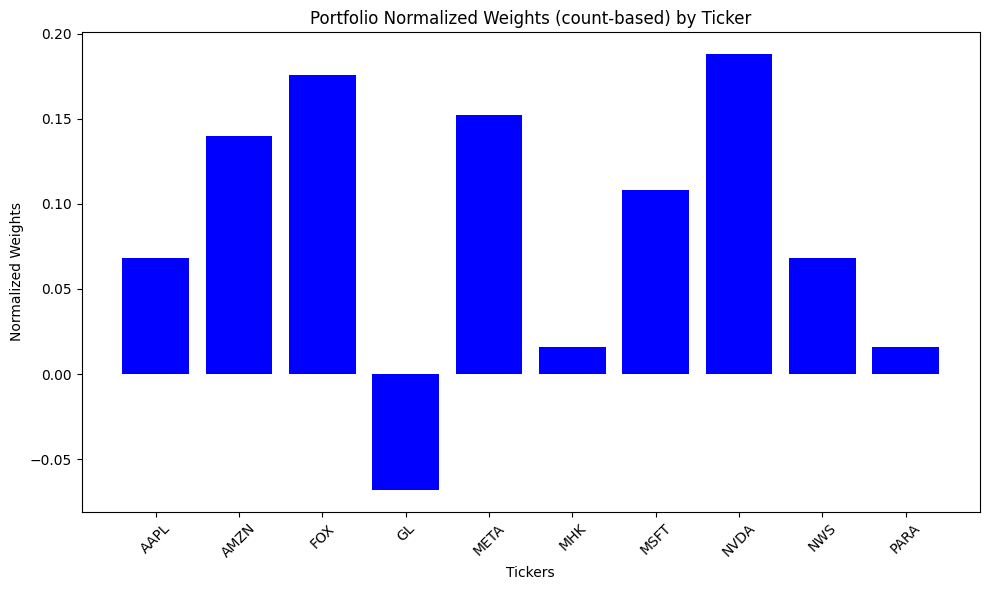

In [58]:
# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(tickers, normalized_weights_counts, color='blue')
plt.xlabel('Tickers')
plt.ylabel('Normalized Weights')
plt.title('Portfolio Normalized Weights (count-based) by Ticker')
plt.xticks(rotation=45)  # Rotate the tick labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated tick labels
plt.savefig("count-based_qm.png")
# Show the plot
plt.show()

In [43]:
def normalize_quantum_portfolio_probability_based(long_selections, short_selections, probabilities, num_assets):
    # Initialize portfolio composition with zeros
    portfolio_composition = np.zeros(num_assets)

    # Iterate over each selection and its corresponding probability
    for i in range(len(probabilities)):
        long_sel = long_selections[i]
        short_sel = short_selections[i]
        prob = probabilities[i]

        # Update the portfolio composition with weighted long and short positions
        portfolio_composition += prob * (long_sel - short_sel)

    # Normalize the portfolio composition to sum to 1 in absolute value
    total_absolute_weight = np.sum(np.abs(portfolio_composition))
    if total_absolute_weight > 0:
        portfolio_composition /= total_absolute_weight
    
    return portfolio_composition


num_assets = len(long[0])  # Number of assets
normalized_weights_probs = normalize_quantum_portfolio_probability_based(long, short, probs, num_assets)

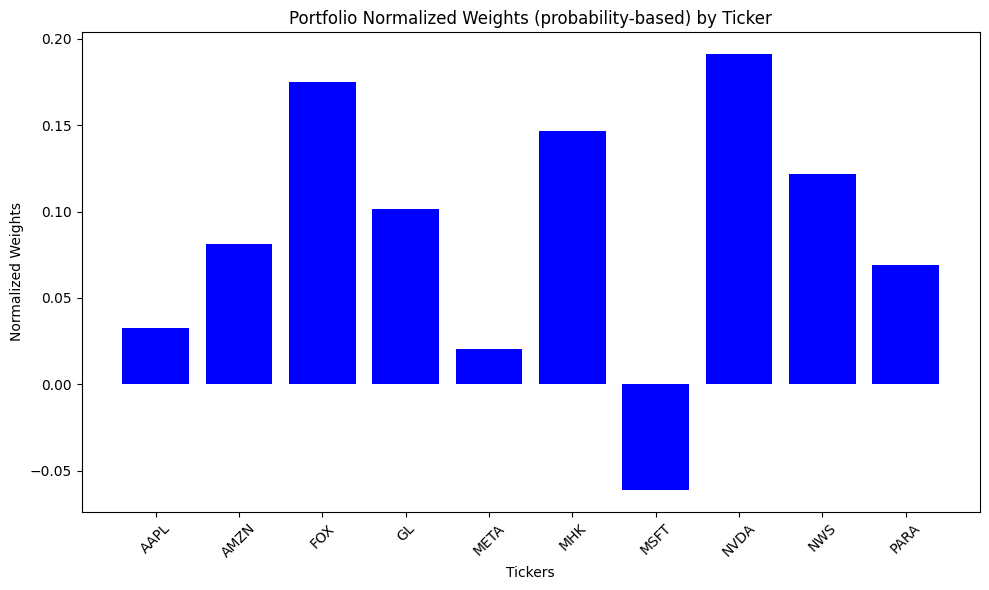

In [59]:
# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(tickers, normalized_weights_probs, color='blue')
plt.xlabel('Tickers')
plt.ylabel('Normalized Weights')
plt.title('Portfolio Normalized Weights (probability-based) by Ticker')
plt.xticks(rotation=45)  # Rotate the tick labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated tick labels
plt.savefig("probability-based_qm.png")
# Show the plot
plt.show()

In [45]:
def normalize_portfolio_with_counts_and_probs(long_counts, short_counts, long_selections, short_selections, probabilities, num_assets):
    # Initialize portfolio composition with zeros
    portfolio_composition = np.zeros(num_assets)

    # Convert selections from array to string for easy comparison and indexing
    long_selection_strings = [''.join(map(str, sel)) for sel in long_selections]
    short_selection_strings = [''.join(map(str, sel)) for sel in short_selections]

    # Accumulate weighted long position counts
    for state, count in long_counts.items():
        if state in long_selection_strings:
            idx = long_selection_strings.index(state)
            prob = probabilities[idx]
            long_sel = np.array([int(bit) for bit in state])
            portfolio_composition += prob * count * long_sel

    # Subtract weighted short position counts
    for state, count in short_counts.items():
        if state in short_selection_strings:
            idx = short_selection_strings.index(state)
            prob = probabilities[idx]
            short_sel = np.array([int(bit) for bit in state])
            portfolio_composition -= prob * count * short_sel

    # Normalize the portfolio composition to sum to 1 in absolute value
    total_absolute_weight = np.sum(np.abs(portfolio_composition))
    normalized_weights = portfolio_composition / total_absolute_weight if total_absolute_weight > 0 else portfolio_composition

    return normalized_weights


num_assets = 10  # Example for the number of assets
normalized_weights_both = normalize_portfolio_with_counts_and_probs(long_counts, short_counts, long, short, probs, num_assets)

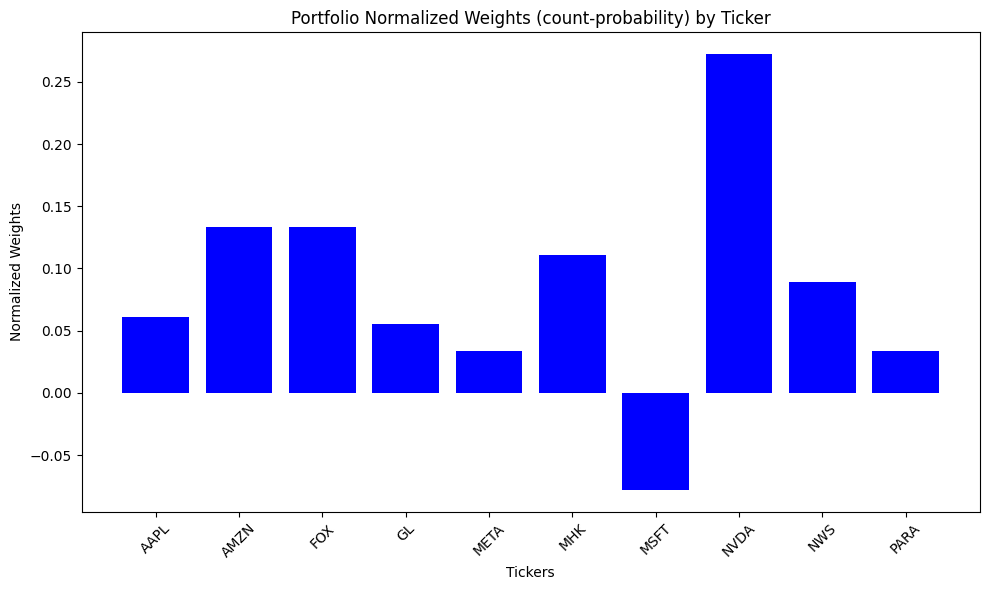

In [60]:
# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(tickers, normalized_weights_both, color='blue')
plt.xlabel('Tickers')
plt.ylabel('Normalized Weights')
plt.title('Portfolio Normalized Weights (count-probability) by Ticker')
plt.xticks(rotation=45)  # Rotate the tick labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated tick labels
plt.savefig("count-probability_qm.png")

# Show the plot
plt.show()

#### Using the same method to get discrete allocations for the optimised weights obtained from normalised weights (probability method) 

In [47]:
weights = dict(zip(tickers, normalized_weights_probs))
latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $17.34 leftover


{'AAPL': 4,
 'AMZN': 9,
 'FOX': 126,
 'GL': 27,
 'META': 1,
 'MHK': 26,
 'NVDA': 5,
 'NWS': 101,
 'PARA': 119,
 'MSFT': -3}

#### Comparison with Classical Optimization Methods

This section compares the performance of quantum computing approaches to traditional classical methods in portfolio optimizatios.


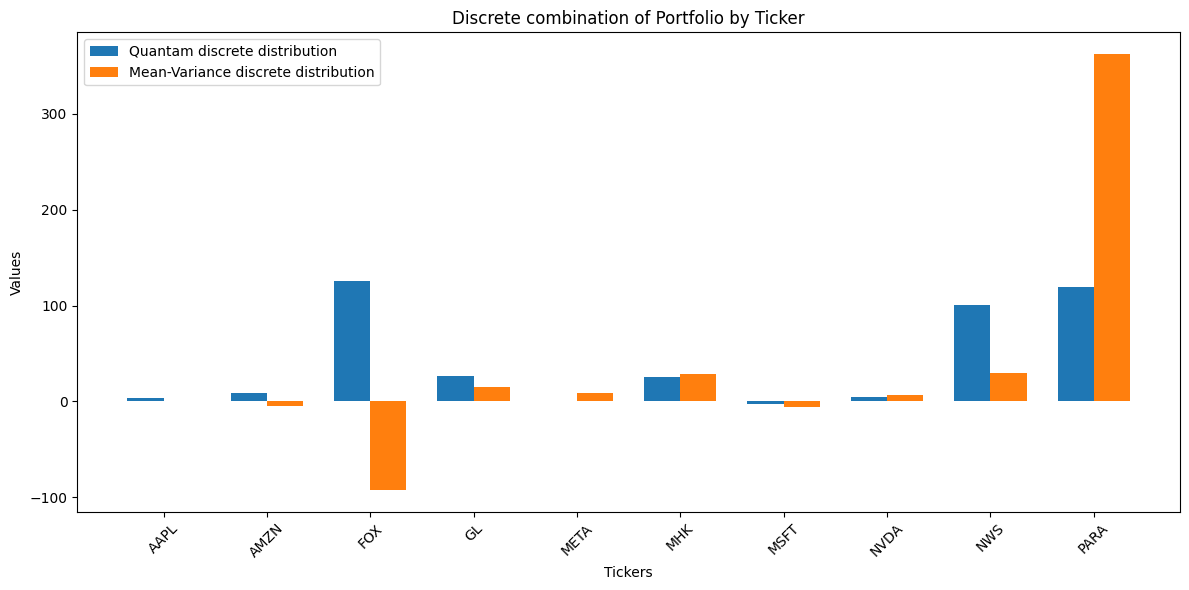

In [61]:
tickers = sorted(alloc.keys())  # Sort or select tickers as required
values1 = [alloc[ticker] for ticker in tickers]
values2 = [alloc_class[ticker] for ticker in tickers]

bar_width = 0.35  # Width of the bars
index = np.arange(len(tickers))

fig, ax = plt.subplots(figsize=(12, 6))


bars1 = ax.bar(index - bar_width/2, values1, bar_width, label='Quantam discrete distribution')


bars2 = ax.bar(index + bar_width/2, values2, bar_width, label='Mean-Variance discrete distribution')

# Adding labels and titles
ax.set_xlabel('Tickers')
ax.set_ylabel('Values')
ax.set_title('Discrete combination of Portfolio by Ticker')
ax.set_xticks(index)
ax.set_xticklabels(tickers)
ax.legend(loc='upper left')
# Rotate tick labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()  
plt.savefig("Discrete_combination_cm_qm.png")

# Show the plot
plt.show()

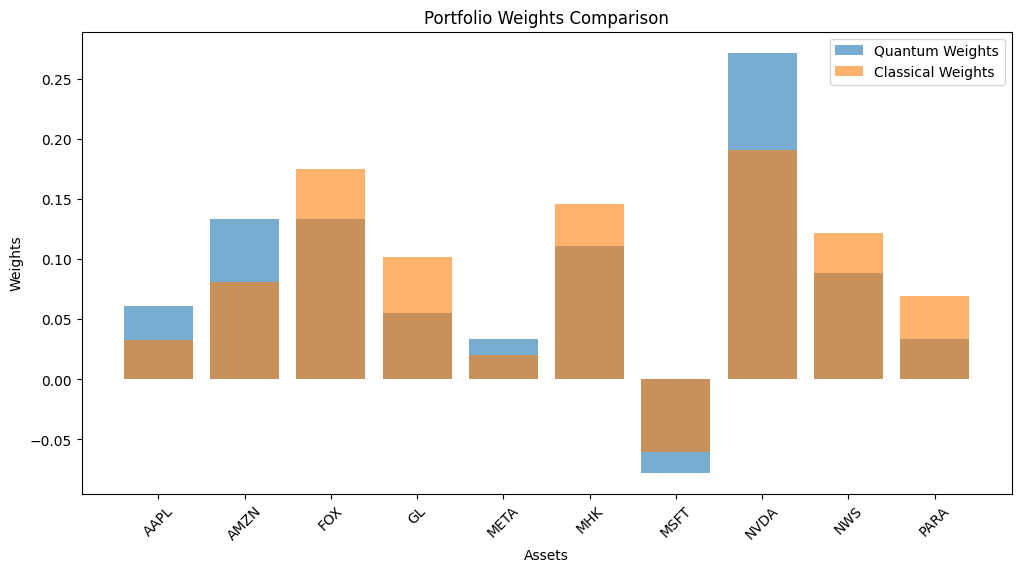

In [62]:
classical_weights = [weights[ticker] for ticker in tickers]

plt.figure(figsize=(12, 6))
plt.bar(tickers, normalized_weights_both, alpha=0.6, label='Quantum Weights')
plt.bar(tickers, classical_weights, alpha=0.6, label='Classical Weights')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Weights Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.savefig("portfolio_weights_cm_qm.png")
plt.show()

### Exploration of Probabilistic Outcomes

This section delves into the various portfolio combinations obtainable from the probability distribution generated by the quantum computation. The inherent parallelism of quantum computing enables us to evaluate multiple potential outcomes simultaneously, showcasing one of the fundamental advantages of this technology in solving optimization problem

Here '1' represents the action to do , which is to long or short and '0' represents no action for every case and combination of assets.s.


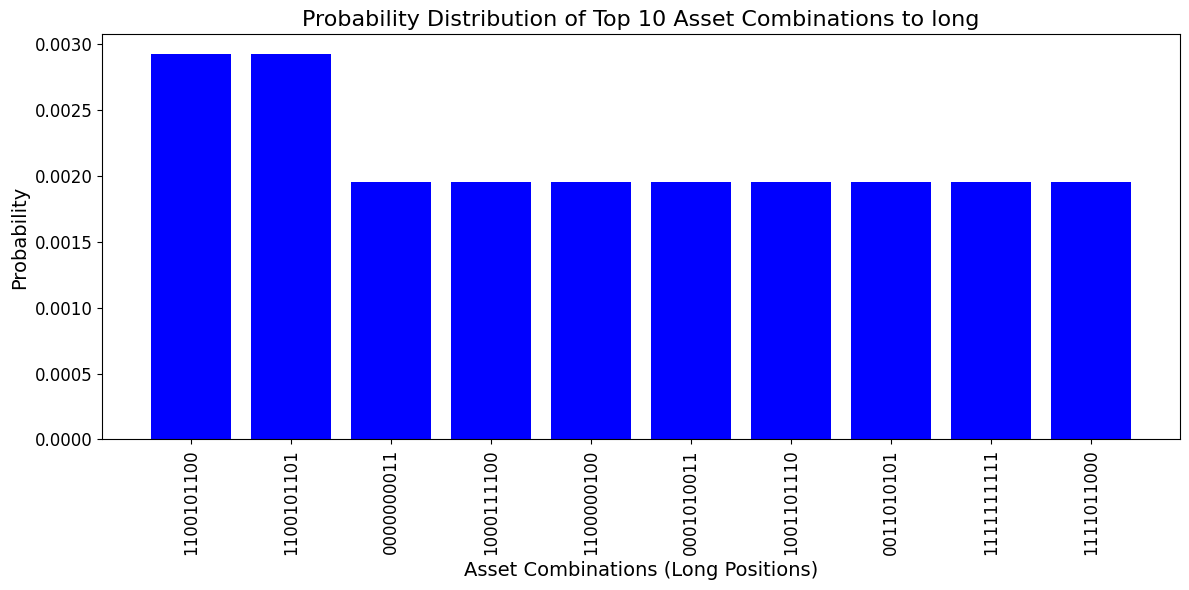

In [63]:
top_n = 10
top_labels = labels_long[:top_n]
top_probs = probs[:top_n]


plt.figure(figsize=(12, 6))
plt.bar(top_labels, top_probs, color='blue')
plt.xlabel('Asset Combinations (Long Positions)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Probability Distribution of Top 10 Asset Combinations to long', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  
plt.savefig("pd_long_qm.png")
plt.show()

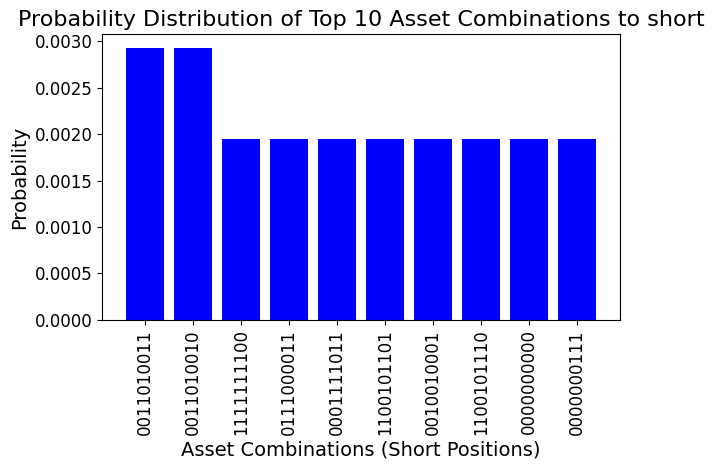

In [64]:
top_n = 10
top_labels = labels_short[:top_n]
top_probs = probs[:top_n]

plt.bar(top_labels, top_probs, color='blue')
plt.xlabel('Asset Combinations (Short Positions)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Probability Distribution of Top 10 Asset Combinations to short', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  
plt.savefig("pd_short_qm.png")

plt.show()

In [52]:
expected_returns_list = []
risks_list = []

# Sort the probabilities to identify the top N configurations
top_indices = np.argsort(probs)[-top_n:]

# Calculate expected return and risk for each of the top N configurations
for i in top_indices:
    # Calculate the portfolio weights as long minus short
    portfolio_weights = long[i] - short[i]
    
    # Calculate expected return for the ith configuration
    expected_return_i = np.dot(portfolio_weights, expected_returns)
    
    # Calculate risk (variance) for the ith configuration
    risk_i = portfolio_weights.T @ covariance_matrix @ portfolio_weights
    
    # Append the results to the lists
    expected_returns_list.append(expected_return_i)
    risks_list.append(risk_i)


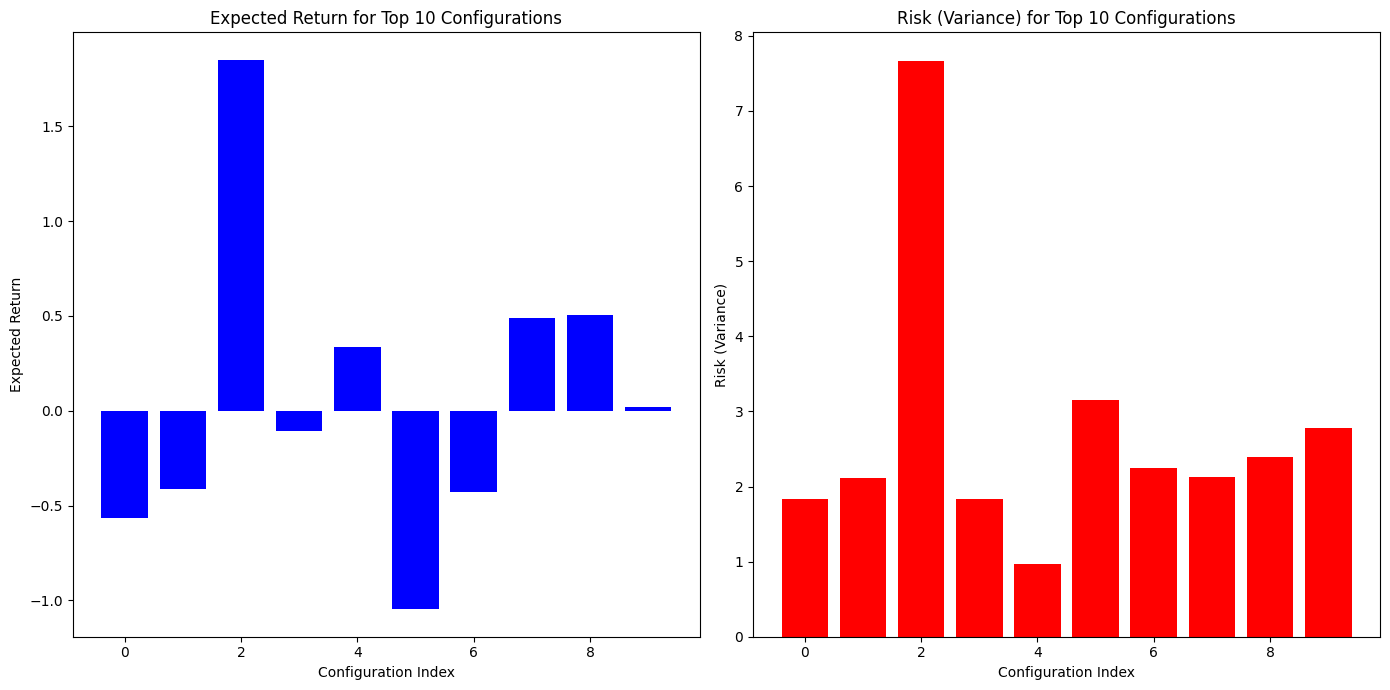

In [65]:
if len(top_indices) > len(expected_returns_list):
    top_indices = top_indices[:len(expected_returns_list)]


plt.figure(figsize=(14, 7))

# Plot for Expected Returns
plt.subplot(1, 2, 1)
plt.bar(range(len(expected_returns_list)), expected_returns_list, color='blue')
plt.xlabel('Configuration Index')
plt.ylabel('Expected Return')
plt.title('Expected Return for Top 10 Configurations')

# Plot for Risks (Variances)
plt.subplot(1, 2, 2)
plt.bar(range(len(risks_list)), risks_list, color='red')
plt.xlabel('Configuration Index')
plt.ylabel('Risk (Variance)')
plt.title('Risk (Variance) for Top 10 Configurations')

plt.tight_layout()
plt.savefig("pd_er_v_qm.png")
plt.show()

### Comparison of Algorithmic Complexity Between Classical and Quantum Approaches

- It is important to note that in our current setup, we are not evaluating the algorithmic complexity in a manner that would allow for direct comparison with classical computational methods. Our simulations are run on classical hardware utilizing the `Sampler()` class, which may not provide an accurate reflection of the quantum resources required for execution. Moreover, due to limitations in our classical computational resources, we do not perform an exhaustive complexity analysis. Quantum computing is anticipated to offer greater efficiency, particularly for large-scale portfolio optimizations involving a substantial number of assets (e.g., over 100 stocks). In contrast, classical algorithms are typically more effective and efficient for smaller-scale problems, such as portfolios with around 10 stocks.


## Further Discussion and Detailed Analysis

For an in-depth analysis and comprehensive commentary on the results of the portfolio optimization using quantum computing, please refer to our extensive report:
- [Detailed Report on Portfolio Optimization Using Quantum Computing](link_to_the_report)
rt)
